In [1]:
import os.path
import tensorflow as tf
import helper
import project_tests as tests
import numpy as np

/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
BATCH_SIZE = 2
LEARNING_RATE = 0.00023949513325777832
KEEP_PROB = 0.49548463810034943

In [3]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    model = tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)

    graph = tf.get_default_graph()

    image_input = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return image_input, keep_prob, layer3, layer4, layer7

# tests.test_load_vgg(load_vgg, tf)

In [4]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    kernel_regularizer = tf.contrib.layers.l2_regularizer(1e-3)
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d()
    
    pool3_1x1 = tf.layers.conv2d(vgg_layer3_out, num_classes, kernel_size=1, 
                                 padding='same', 
                                 kernel_initializer=kernel_initializer, 
                                 kernel_regularizer=kernel_regularizer)
    
    pool4_1x1 = tf.layers.conv2d(vgg_layer4_out, num_classes, kernel_size=1, 
                                 padding='same', 
                                 kernel_initializer=kernel_initializer, 
                                 kernel_regularizer=kernel_regularizer)
    
    conv7_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, kernel_size=1, 
                                 padding='same', 
                                 kernel_initializer=kernel_initializer, 
                                 kernel_regularizer=kernel_regularizer)
    
    # make prediction of segmentation
    deconv7 = tf.layers.conv2d_transpose(conv7_1x1, num_classes, kernel_size=4, strides=2, padding='same',
                                         kernel_initializer=kernel_initializer, 
                                         kernel_regularizer=kernel_regularizer)
    
    fuse1 = tf.add(deconv7, pool4_1x1)
    deconv_fuse1 = tf.layers.conv2d_transpose(fuse1, num_classes, kernel_size=4, strides=2, padding='same',
                                              kernel_initializer=kernel_initializer,
                                              kernel_regularizer=kernel_regularizer)
    
    fuse2 = tf.add(deconv_fuse1, pool3_1x1)
    
    out = tf.layers.conv2d_transpose(fuse2, num_classes, kernel_size=16, strides=8, padding='same',
                                     kernel_initializer=kernel_initializer, 
                                     kernel_regularizer=kernel_regularizer)
    
    return out
# tests.test_layers(layers)

In [5]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label))
#     train_op = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(cross_entropy_loss)
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_loss)
    
    return logits, train_op, cross_entropy_loss
# tests.test_optimize(optimize)

In [6]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    sess.run(tf.global_variables_initializer())
    loss_per_epoch = []
    for epoch in range(epochs):
        losses, i = [], 0
        for images, labels in get_batches_fn(batch_size):
            i += 1
            feed_dict = {input_image: images, 
                         correct_label: labels, 
                         keep_prob: KEEP_PROB, 
                         learning_rate: LEARNING_RATE}
            _, loss = sess.run([train_op, cross_entropy_loss], feed_dict=feed_dict)
            losses.append(loss)
        
        training_loss = sum(losses) / len(losses)
        loss_per_epoch.append(training_loss)
        print(" [-] epoch: %d/%d, loss: %.5f" % (epoch+1, epochs, training_loss))
    return loss_per_epoch

# tests.test_train_nn(train_nn)

In [7]:
num_classes = 2
image_shape = (160, 576)
data_dir = './data'
runs_dir = './runs'
tests.test_for_kitti_dataset(data_dir)

# Download pretrained vgg model
helper.maybe_download_pretrained_vgg(data_dir)

# OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
# You'll need a GPU with at least 10 teraFLOPS to train on.
#  https://www.cityscapes-dataset.com/

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

# Path to vgg model
vgg_path = os.path.join(data_dir, 'vgg')
# Create function to get batches
get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

# OPTIONAL: Augment Images for better results
#  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

# TODO: Build NN using load_vgg, layers, and optimize function
image_input, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
out = layers(layer3, layer4, layer7, num_classes)

correct_label = tf.placeholder(tf.int32)
learning_rate = tf.placeholder(tf.float32)
logits, train_op, cross_entropy_loss = optimize(out, correct_label, learning_rate, num_classes)

# TODO: Train NN using the train_nn function
epochs = 30
batch_size = BATCH_SIZE
loss_per_epoch = train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, image_input, correct_label, keep_prob, learning_rate)

Tests Passed
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
 [-] epoch: 1/30, loss: 3.28263
 [-] epoch: 2/30, loss: 0.70379
 [-] epoch: 3/30, loss: 0.66155
 [-] epoch: 4/30, loss: 0.63797
 [-] epoch: 5/30, loss: 0.61965
 [-] epoch: 6/30, loss: 0.60346
 [-] epoch: 7/30, loss: 0.58569
 [-] epoch: 8/30, loss: 0.55632
 [-] epoch: 9/30, loss: 0.44355
 [-] epoch: 10/30, loss: 0.24563
 [-] epoch: 11/30, loss: 0.18292
 [-] epoch: 12/30, loss: 0.15251
 [-] epoch: 13/30, loss: 0.13415
 [-] epoch: 14/30, loss: 0.11705
 [-] epoch: 15/30, loss: 0.10362
 [-] epoch: 16/30, loss: 0.09700
 [-] epoch: 17/30, loss: 0.09713
 [-] epoch: 18/30, loss: 0.08529
 [-] epoch: 19/30, loss: 0.07571
 [-] epoch: 20/30, loss: 0.07254
 [-] epoch: 21/30, loss: 0.06490
 [-] epoch: 22/30, loss: 0.06402
 [-] epoch: 23/30, loss: 0.07886
 [-] epoch: 24/30, loss: 0.05911
 [-] epoch: 25/30, loss: 0.05304
 [-] epoch: 26/30, loss: 0.04957
 [-] epoch: 27/30, loss: 0.04735
 [-] epoch: 28/30, loss: 0.04

In [8]:
# TODO: Save inference data using helper.save_inference_samples
#  helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, image_input)

# OPTIONAL: Apply the trained model to a video

Training Finished. Saving test images to: ./runs/1511773860.2436142


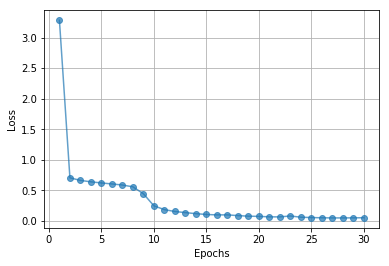

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

ep = np.linspace(1,epochs,epochs)
plt.plot(ep, loss_per_epoch, '-o', alpha=0.7)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()